# Modelos LSTM

## 1. Introducción a LSTM

LSTM es un acrónimo de *Long-Short Term Memory* y representa a un **subtipo de RNN** (*Recurrent Neural Network*) capaz de **retener información relevante** sobre datos ya procesados que ayude al procesamiento de nuevas secuencias de datos completas. Su arquitectura se encuentra compuesta a su vez por tres redes neuronales:

* ***Forget Gate***: este primer modelo es el encargado de filtrar qué información previa es útil para su almacenamiento y qué datos ya no son útiles para futuras iteraciones. 

* ***Input Gate***: esta segunda red trata de determinar el valor que presentan los datos entrantes para resolver la tarea de clasificación.

* ***Output Gate***: finalmente esta red calcula las salidas del modelo LSTM que dependerán de la tarea de clasificación que se pretende abordar.

### 1.1. Condiciones de uso

Dependiendo del framework que se pretenda utilizar (Tensorflow, Keras, Pytorch) existen diferentes tratamientos de datos y requisitos de implementación que se deben cumplir al definir la arquitectura, entrenamiento y validación de modelos. En mi caso particular he optado por utilizar **Keras** debido a la experiencia previa que tengo con la librería y a su facilidad de uso. 

1. **Procesamiento y limpieza** de los documentos.

2. **Tokenización** de los documentos especificando un token para aquellos términos que no sean reconocidos dentro de un vocabulario de palabras.

3. **Codificación** numérica en forma de matrices secuenciales de valores. 

5. **Normalización** de las secuencias numéricas para establecer un mismo tamaño fijo, completando con ceros aquellas de menor longitud y separando en varias secuencias aquellas que dispongan de un mayor tamaño.

6. Definición de la arquitectura de un **modelo** e instanciación para su posterior entrenamiento y validación.

### 1.2. Casos de uso

* Detección y extracción de patrones en secuencias de datos.
* Modelado del lenguaje natural.
* Traducción de texto.
* Reconocimiento de textos manuscritos.
* Generación de imágenes mediante mecanismos de atención.
* Sistemas de preguntas y respuestas.
* Conversión de vídeo a texto.

## 2. Estructura del notebook

1. Introducción a LSTM
2. Estructura del notebook
3. Instalación y carga de librerías
4. Lectura y carga de datos
5. Experimentos y modelos
6. Conclusiones

## 3. Instalación y carga de librerías

Este apartado tiene como único propósito cargar las librerías y dependencias necesarias para la ejecución de este notebook, así como las funciones propiamente desarrolladas. Previo a ello deberán ser instaladas bien ejecutando el script *setup.sh* mediante el comando `bash setup.sh` con permisos de ejecución en distribuciones Linux, o bien ejecutando el compando `pip install -r requirements.txt`.

In [12]:
%%capture

# !pip install -r ../requirements.txt

import sys
sys.path.append('../scripts')

# Import data read and compute functions
from data import read_train_dataset, read_test_dataset

# Import text preprocess functions
from processing import *

# numpy: to work with numeric codifications and embeddings
import numpy as np

# keras: to define and build LSTM models
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.models import Model

# sklearn: to plot a confusion matrix per trained model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# matplotlib: to plot charts
import matplotlib.pyplot as plt

## 4. Lectura y carga de datos originales

En esta sección se pretende **cargar los datasets de entrenamiento y validación** procedentes de los correspondientes ficheros situados en la carpeta *data*. Al tener un **formato TSV** se deben leer como tablas aunque posteriormente se trabaje con ellos en formato *dataframe*. 

Tal y como se puede comprobar en los siguientes resultados las dimensiones de sendos conjuntos de datos se detallan a continuación:

* Conjunto de entrenamiento: **6.977 muestras**.
* Conjunto de validación: **4.368 muestras**.

In [2]:
# Read EXIST datasets
train_df = read_train_dataset()
test_df = read_test_dataset()

# Show the dimensions of the datasets
print("Train dataset dimensions:", train_df.shape)
print("Test dataset dimensions:", test_df.shape)

Train dataset dimensions: (6977, 7)
Test dataset dimensions: (4368, 7)


## 5. Experimentos y modelos

A continuación se detallan los experimentos más relevantes de entre las distintas pruebas realizadas mediante diversas combinaciones de técnicas de procesamiento de textos, codificación de documentos y arquitecturas LSTM. A continuación se definen tres funciones comunes a todos los experimentos para el tratamiento y codificación de documentos, carga de embeddings pre-entrenados y validación de modelos.

In [3]:
def get_train_test_matrix(max_n_words: int, sequence_len: int, 
                          lemm: bool = False, stemm: bool = False):
    # Process train and test text documents
    processed_df = process_encode_datasets(
        train_df=train_df, 
        test_df=test_df,
        lemm=False, 
        stemm=False
    )

    # Processed train texts and encoded train labels 
    train_texts = list(processed_df["train_df"]["cleaned_text"].values)
    train_labels = processed_df["encoded_train_labels"]

    # Processed test texts and encoded test labels
    test_texts = list(processed_df["test_df"]["cleaned_text"].values)
    test_labels = processed_df["encoded_test_labels"]

    # Createa a tokenizer based on train texts
    tokenizer = Tokenizer(num_words=max_n_words)
    tokenizer.fit_on_texts(train_texts)

    # Transform each text into a numeric sequence
    train_sequences = tokenizer.texts_to_sequences(train_texts)

    # Transform each numeric sequence into a 2D vector
    train_matrix = pad_sequences(
        sequences=train_sequences, 
        maxlen=sequence_len)

    # Tokenize the test documents using the prior trained tokenizer
    test_sequences = tokenizer.texts_to_sequences(test_texts)

    # Transform each numeric sequence into a 2D vector
    test_matrix = pad_sequences(
        sequences=test_sequences,
        maxlen=sequence_len)

    return {
        "tokenizer": tokenizer,
        "train_matrix": train_matrix,
        "train_labels": train_labels,
        "test_matrix": test_matrix,
        "test_labels": test_labels
    }

In [4]:
def get_embedding_matrix(embedding_file, tokenizer, sequence_len):
    # Load the embeddings stored in a TXT file
    embedding_file = open(embedding_file)

    # Store each word with its embeddings
    embeddings_index = {
        line.split()[0]:np.asarray(line.split()[1:], dtype='float32') 
        for line in embedding_file
    }

    # Initialize the embedding matrix with zeros
    embedding_matrix = np.zeros(shape=(len(tokenizer.word_index)+1, sequence_len))

    # Complete the matrix with the prior loaded embeddings
    for word, i in tokenizer.word_index.items():
        # Search for the embeddings of each word
        embedding_vector = embeddings_index.get(word)

        # Words not found will be zeros
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix    

In [5]:
def validate_lstm_model(model, train_matrix, train_labels, test_matrix, test_labels):
    # Compute and print the accuracy and AUC over train
    train_acc = model.evaluate(
        x=train_matrix, 
        y=np.array(train_labels))

    print(f"Accuracy over train dataset: {train_acc[1]}")
    print(f"AUC over train dataset: {train_acc[2]}\n")

    # Compute and print the accuracy and AUC over test
    test_acc = model.evaluate(
        x=test_matrix, 
        y=np.array(test_labels))

    print(f"Accuracy over test dataset: {test_acc[1]}")
    print(f"AUC over test dataset: {test_acc[2]}")

    # Generate class label predictions over the test dataset
    # Class 0 ~ <= 0.5 | Class 1 ~ > 0.5
    test_preds = (model.predict(test_matrix) > 0.5).astype("int32")

    # Plot the confusion matrix 
    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(
            np.array(test_labels), 
            np.array(test_preds)), 
        display_labels=["Non-sexist", "Sexist"]) \
    .plot()
    plt.show()

### 5.1. Primer experimento: LSTM básica

* **Procesamiento de texto** para los conjuntos de entrenamiento y test aplicando las siguientes técnicas.
  - Elimina caracteres especiales, no alfabéticos y signos de puntuación.
  - Elimina hashtags y menciones de usuarios.
  - Elimina *stopwords* de los documentos en inglés y español.
  - <p>Convierte todos los caracteres en minúsculas.</p>

* **Codificación de documentos** 
  - Tanto para entrenamiento como para test se ha empleado el conjunto ***Glove 6B 50d*** de embeddings pre-entrenados disponibles online. <p></p>

* **Arquitectura del modelo**. Se trata de una arquitectura muy básica para comenzar las pruebas.
  - 1 capa de entrada: para proporcionar la matriz de datos.
  - 1 capa de embeddings: para proporcionar los embeddings pre-entrenados de Glove 6B 50d.
  - 1 capa LSTM: con 64 neuronas ocultas para la extracción de características.
  - 1 capa de salida: para unificar los datos de la capa anterior en una única salida. 
  - <p>Función de activación: sigmoidal para calcular la probabilidad de pertenencia de cada muestra.</p>

* Configuración para las fases de **entrenamiento y validación**.
  - Tamaño de cada lote: 128.
  - Número de épocas de entrenamiento: 10.
  - % de datos para validación durante entrenamiento: 20%.
  - Métricas de validación sobre entrenamiento y test: *accuracy* y AUC.
  - <p>Métrica de validación únicamente sobre test: matriz de confusión.</p>

In [6]:
LSTM1_MAX_N_WORDS = 1000
LSTM1_SEQUENCE_MAX_LEN = 50

# Create a tokenizer based on the train texts
# Process train and test texts
lstm1_data = get_train_test_matrix(
    max_n_words=LSTM1_MAX_N_WORDS,
    sequence_len=LSTM1_SEQUENCE_MAX_LEN,
    lemm=False,
    stemm=False
)

print(f"Train matrix:\n{lstm1_data['train_matrix']}")
print(f"Train labels:{lstm1_data['train_labels'][0:5]}")

print(f"\nTest matrix:\n{lstm1_data['test_matrix']}")
print(f"Test labels:{lstm1_data['test_labels'][0:5]}")

Train matrix:
[[  0   0   0 ... 210 761  92]
 [  0   0   0 ... 139 466 842]
 [  0   0   0 ... 255 256 183]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...  53 324 509]
 [  0   0   0 ...   2 726   7]]
Train labels:[1, 0, 1, 0, 0]

Test matrix:
[[  0   0   0 ... 259 297  32]
 [  0   0   0 ... 109   3  48]
 [  0   0   0 ... 911 179 911]
 ...
 [  0   0   0 ... 522 413  97]
 [  0   0   0 ...   7  36 455]
 [  0   0   0 ...   5 102 166]]
Test labels:[0, 0, 1, 1, 0]


In [7]:
LSTM1_EMBEDDING_FILE_PATH = "../embeddings/glove.6B.50d.txt"

# Load the embeddings stored in the defined file path
# Encode the train matrix with these embeddings
lstm1_embedding_matrix = get_embedding_matrix(
    embedding_file=LSTM1_EMBEDDING_FILE_PATH,
    tokenizer=lstm1_data["tokenizer"],
    sequence_len=LSTM1_SEQUENCE_MAX_LEN
)

lstm1_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.95897001,  0.86149001, -0.53064001, ..., -1.0158    ,
        -0.35795   , -0.31110999],
       [ 0.90706998,  0.50944   , -0.78408003, ..., -1.18550003,
         0.84682   ,  0.68440002],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [8]:
# LSTM ARCHITECTURE
## Input layer
input_layer = Input(
    name="inputs",
    shape=[LSTM1_SEQUENCE_MAX_LEN])

## Embedding layer: pre-trained embeddings
layer = Embedding(
    input_dim=len(lstm1_data["tokenizer"].word_index)+1,
    output_dim=LSTM1_SEQUENCE_MAX_LEN,
    weights=[lstm1_embedding_matrix],
    input_length=LSTM1_MAX_N_WORDS,
    trainable=False)(input_layer)

## LSTM layer
layer = LSTM(units=64)(layer)

## Output layer
layer = Dense(
    name="output",
    units=1)(layer)

## Activation layer
output_layer = Activation(activation="sigmoid")(layer)

# CREATE A LSTM MODEL WITH THE PRIOR ARCHITECTURE
## Model object
lstm_model1 = Model(
    inputs=input_layer,
    outputs=output_layer)

## Summary of the model
lstm_model1.summary()

## Compile the model 
lstm_model1.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy", "AUC"])

2023-01-22 14:23:21.096392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1207500   
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 1,237,005
Trainable params: 29,505
Non-trainable params: 1,207,500
_________________________________________________________________


In [9]:
# LSTM TRAINING
## Train the prior built model
lstm_model1.fit(
    x=lstm1_data["train_matrix"], 
    y=np.array(lstm1_data["train_labels"]),
    batch_size=128,
    epochs=10,
    validation_split=0.2)

Epoch 1/10
44/44 [==============================] - 3s 40ms/step - loss: 0.6663 - accuracy: 0.6008 - auc: 0.6121 - val_loss: 0.8172 - val_accuracy: 0.3302 - val_auc: 0.5471
Epoch 2/10
44/44 [==============================] - 1s 26ms/step - loss: 0.6396 - accuracy: 0.6321 - auc: 0.6740 - val_loss: 0.8422 - val_accuracy: 0.3546 - val_auc: 0.5648
Epoch 3/10
44/44 [==============================] - 1s 28ms/step - loss: 0.6274 - accuracy: 0.6454 - auc: 0.6954 - val_loss: 0.7090 - val_accuracy: 0.5072 - val_auc: 0.5716
Epoch 4/10
44/44 [==============================] - 1s 26ms/step - loss: 0.6206 - accuracy: 0.6579 - auc: 0.7039 - val_loss: 0.8274 - val_accuracy: 0.4169 - val_auc: 0.5749
Epoch 5/10
44/44 [==============================] - 1s 26ms/step - loss: 0.6086 - accuracy: 0.6762 - auc: 0.7221 - val_loss: 0.8698 - val_accuracy: 0.4112 - val_auc: 0.5812
Epoch 6/10
44/44 [==============================] - 1s 27ms/step - loss: 0.6026 - accuracy: 0.6793 - auc: 0.7299 - val_loss: 0.7339 - v

Tal y como se puede apreciar en los siguientes resultados con una LSTM básica se ha podido conseguir un **tasa de aciertos del 66% en entrenamiento y 61% en test**, por lo que al no haber una diferencia considerable entre ambas cifras parece que el modelo **no ha sobreaprendido**. Por lo tanto es probable que se deba ajustar mejor tanto la arquitectura como la configuración de entrenamiento para aumentar la capacidad de estudio en los datos de entrenamiento y así mejorar su rendimiento. 

Observando las cifras disponibles del área bajo la curva ROC (*AUC*) se determina que este modelo **apenas dispone de capacidad predictiva** puesto que valor ni siquiera alcanza un 70%.

Finalmente observando la matriz de confusión se destacan dos principales aspectos: el primero es que el clasificador ha sido capaz de **identificar mejor los textos no sexistas** puesto que la tasa de aciertos de la clase negativa es bastante superior al de la positiva, mientras que por otro lado la cifra de **falsos negativos es desmesurada** lo que significa que el clasificador no está reconociendo adecuadamente las características de los documentos sexistas.

219/219 [==============================] - 1s 5ms/step - loss: 0.6264 - accuracy: 0.6692 - auc: 0.7249
Accuracy over train dataset: 0.6691988110542297
AUC over train dataset: 0.724897563457489

137/137 [==============================] - 1s 5ms/step - loss: 0.6985 - accuracy: 0.6126 - auc: 0.6660
Accuracy over test dataset: 0.6126373410224915
AUC over test dataset: 0.6659905910491943
137/137 [==============================] - 1s 5ms/step


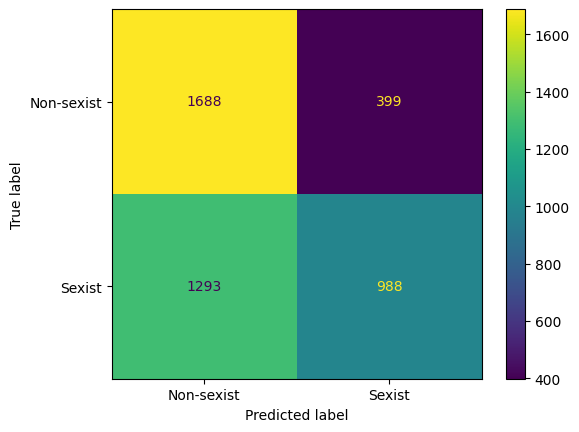

In [10]:
## LSTM VALIDATION
## Evaluate the trained LSTM model over train and test datasets
validate_lstm_model(
    model=lstm_model1,
    train_matrix=lstm1_data["train_matrix"],
    train_labels=lstm1_data["train_labels"],
    test_matrix=lstm1_data["test_matrix"],
    test_labels=lstm1_data["test_labels"]
)